In [111]:
import pandas as pd
import os
import tensorflow as tf
import base64
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt

## Generate Annotations File from CSV

In [7]:
csv_folder_path = "D:/Documents/projects/Multi-Class-Object-Detection-Model/OIDv4_ToolKit/OID/csv_folder"
classes_data = pd.read_csv(f"{csv_folder_path}/class-descriptions-boxable.csv", header=None)

classes_data.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [8]:
classes = ['Billboard', 'Street light']

In [26]:
class_strings = []
class_labels = {}

for i in classes:
    req_classes = classes_data[classes_data[1] == i]
    string = req_classes.values[0][0]
    class_strings.append(string)
    class_labels[string] = i

class_strings, class_labels

(['/m/01knjb', '/m/033rq4'],
 {'/m/01knjb': 'Billboard', '/m/033rq4': 'Street light'})

In [100]:
def process_annotation_csv(csv_folder_path, csv_file_name, class_strings, class_labels):
    
    annotation_data = pd.read_csv(f'{csv_folder_path}/{csv_file_name}', usecols=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])
    
    # print(annotation_data.head(1))

    filtered_class_data = annotation_data.loc[annotation_data['LabelName'].isin(class_strings)].copy()
    
    # print(filtered_class_data.head(1))

    filtered_class_data['classNumber'] = ''

    for i in range(len(class_strings)):
        filtered_class_data.loc[filtered_class_data['LabelName'] == class_strings[i], 'classNumber'] = i

    filtered_class_data['LabelName'] = filtered_class_data['LabelName'].replace(class_labels)
    
    # print(filtered_class_data.head(1))

    final_df = filtered_class_data[['ImageID', 'LabelName', 'classNumber', 'XMin', 'YMin', 'XMax', 'YMax']].copy()
    # print(final_df.head(1))

    try:
        final_df.loc[final_df['LabelName'] == 'Street light', 'ImageID'] = final_df['ImageID'].replace(['a467a9209e8ea07d', 'b18590912ef42303', 'bc837dde095d59e3', 'd917d8be9cfe7e80'],
                                    ['a467a9209e8ea07d1', 'b18590912ef423032', 'bc837dde095d59e33', 'd917d8be9cfe7e804'])
    except:
        pass
    
    return final_df

In [102]:
train_annotations_df = process_annotation_csv(csv_folder_path ,'train-annotations-bbox.csv', class_strings, class_labels)
val_annotations_df = process_annotation_csv(csv_folder_path ,'validation-annotations-bbox.csv', class_strings, class_labels)
test_annotations_df = process_annotation_csv(csv_folder_path ,'test-annotations-bbox.csv', class_strings, class_labels)

In [103]:
train_annotations_df.shape, val_annotations_df.shape, test_annotations_df.shape

((54520, 7), (51, 7), (292, 7))

In [106]:
train_annotations_df.head()

,ImageID,LabelName,classNumber,XMin,YMin,XMax,YMax
79,00001bc2c4027449,Street light,1,0.240625,0.072500,0.276250,0.143333
80,00001bc2c4027449,Street light,1,0.378750,0.316667,0.394375,0.377500
735,000069a0b17c906e,Street light,1,0.000625,0.612381,0.058125,0.862857
736,000069a0b17c906e,Street light,1,0.271875,0.332381,0.384375,0.894286
1757,0000e2d480cfb105,Street light,1,0.569149,0.692819,0.586879,0.760638


In [107]:
def generate_annotation_json_files(data_dir, annotation_df):
    for image_name in os.listdir(data_dir + 'images/'):
        if image_name.endswith('.jpg'):
            image = Image.open(data_dir + 'images/' + image_name)
            image_bytes = image.tobytes()
            base64_encoded = base64.b64encode(image_bytes).decode('utf-8')
            width, height = image.size
            
            image_title = image_name[:-4]
            
            image_annotations = annotation_df[annotation_df['ImageID'] == image_title]
            
            shapes_list = []

            # Iterate through each row in the DataFrame
            for index, row in image_annotations.iterrows():
                # Create a custom JSON object for each row
                custom_json = {
                    'label': row['LabelName'],
                    'points': [
                        [
                            row['XMin'],
                            row['YMin']
                        ],
                        [
                            row['XMax'],
                            row['YMax']
                        ]
                    ],
                    "group_id": None,
                    "shape_type": "rectangle",
                    "flags": {}
                }
                # Append the custom JSON object to the list
                shapes_list.append(custom_json)
            
            annotations = ({
                        "version": "5.5.0",
                        "flags": {},
                        "shapes": [
                        {
                            "label": image_annotations.iloc[0, 1],
                            "points": [
                            [
                                image_annotations.iloc[0, 3],
                                image_annotations.iloc[0, 4]
                            ],
                            [
                                image_annotations.iloc[0, 5],
                                image_annotations.iloc[0, 6]
                            ]
                            ],
                            
                        }
                        ],
                        "imagePath": image_name,
                        "imageData": base64_encoded[:1000] + '...',
                        "imageHeight": height,
                        "imageWidth": width
                    })
            
            annotation_file_path = data_dir + '/labels/' + image_title + '.json'
            with open(annotation_file_path, 'w') as f:
                json.dump(annotations, f, indent=4)        

In [108]:
# # Path to the output text file
# classes_file_path = "D:/Documents/projects/Multi-Class-Object-Detection-Model/OIDv4_ToolKit/OID/Dataset/classes.txt"

# # Write the list to a text file
# with open(classes_file_path, 'w') as f:
#     for item in classes:
#         f.write("%s\n" % item)

In [109]:
train_dir = "D:/Downloads/Dataset/train/"
val_dir = "D:/Downloads/Dataset/validation/"
test_dir = "D:/Downloads/Dataset/test/"

In [110]:
generate_annotation_json_files(train_dir, train_annotations_df)
generate_annotation_json_files(val_dir, val_annotations_df)
generate_annotation_json_files(test_dir, test_annotations_df)

## TF Data Pipeline

In [113]:
train_images = tf.data.Dataset.list_files(train_dir + 'images/*.jpg')

In [114]:
train_images.as_numpy_iterator().next()

b'D:\\Downloads\\Dataset\\train\\images\\c776f7ede45fbd27.jpg'

In [120]:
def load_image(image_path):
    byte_image = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [116]:
train_images = train_images.map(load_image)

In [117]:
train_images.as_numpy_iterator().next()

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[55, 23,  0],
        [51, 20,  0],
        [49, 18,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[48, 19,  1],
        [45, 18,  0],
        [45, 17,  3],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[41, 13,  1],
        [37, 11,  0],
        [31,  7,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [122]:
def load_image_dataset(data_dir):
    dataset = tf.data.Dataset.list_files(data_dir + 'images/*.jpg')
    dataset = dataset.map(load_image)
    return dataset

In [123]:
train_images = load_image_dataset(train_dir)
val_images = load_image_dataset(val_dir)
test_images = load_image_dataset(test_dir)

In [129]:
train_images.as_numpy_iterator().next()

array([[[40, 70, 70],
        [33, 63, 63],
        [44, 74, 74],
        ...,
        [18, 22, 34],
        [20, 22, 35],
        [20, 22, 35]],

       [[37, 67, 67],
        [38, 68, 68],
        [49, 79, 79],
        ...,
        [19, 23, 35],
        [20, 22, 35],
        [21, 23, 36]],

       [[40, 71, 73],
        [39, 70, 72],
        [45, 77, 76],
        ...,
        [19, 23, 35],
        [21, 23, 36],
        [22, 24, 37]],

       ...,

       [[69, 82, 52],
        [65, 79, 46],
        [63, 77, 44],
        ...,
        [16, 15, 21],
        [16, 15, 21],
        [16, 15, 21]],

       [[78, 90, 54],
        [75, 87, 51],
        [80, 92, 56],
        ...,
        [16, 15, 21],
        [16, 15, 21],
        [16, 15, 21]],

       [[79, 89, 52],
        [82, 92, 55],
        [78, 90, 54],
        ...,
        [16, 15, 21],
        [16, 15, 21],
        [16, 15, 21]]], dtype=uint8)

In [128]:
val_images.as_numpy_iterator().next()

array([[[64, 38, 21],
        [63, 37, 20],
        [63, 37, 20],
        ...,
        [25, 26, 21],
        [24, 25, 20],
        [24, 25, 20]],

       [[66, 40, 23],
        [66, 40, 23],
        [67, 41, 24],
        ...,
        [23, 24, 19],
        [23, 24, 19],
        [24, 25, 20]],

       [[67, 42, 22],
        [68, 43, 23],
        [69, 44, 24],
        ...,
        [23, 24, 19],
        [24, 25, 20],
        [25, 26, 21]],

       ...,

       [[63, 50, 34],
        [58, 45, 29],
        [56, 43, 26],
        ...,
        [23, 24, 16],
        [24, 25, 17],
        [26, 27, 19]],

       [[57, 45, 29],
        [56, 44, 28],
        [60, 47, 30],
        ...,
        [24, 25, 17],
        [23, 24, 16],
        [23, 24, 16]],

       [[60, 48, 32],
        [61, 49, 33],
        [67, 54, 37],
        ...,
        [26, 27, 19],
        [24, 25, 17],
        [23, 24, 16]]], dtype=uint8)

In [127]:
test_images.as_numpy_iterator().next()

array([[[254, 255, 250],
        [254, 255, 250],
        [254, 255, 250],
        ...,
        [217, 231, 234],
        [220, 231, 235],
        [219, 230, 234]],

       [[254, 255, 250],
        [254, 255, 250],
        [254, 255, 250],
        ...,
        [218, 229, 233],
        [219, 230, 234],
        [218, 229, 233]],

       [[254, 254, 252],
        [254, 254, 252],
        [254, 255, 250],
        ...,
        [217, 231, 234],
        [216, 229, 235],
        [215, 228, 234]],

       ...,

       [[  9,  11,   8],
        [  9,  11,   8],
        [  9,  11,   8],
        ...,
        [ 23,  23,  23],
        [ 21,  21,  19],
        [ 21,  21,  19]],

       [[  8,  10,   7],
        [  9,  11,   8],
        [ 10,  10,   8],
        ...,
        [ 26,  27,  31],
        [ 22,  26,  27],
        [ 23,  27,  28]],

       [[ 10,  12,   9],
        [ 10,  12,   9],
        [ 11,  11,   9],
        ...,
        [ 26,  29,  34],
        [ 26,  27,  31],
        [ 28,  29,  33]]

## View raw images

In [145]:
images_generator = train_images.as_numpy_iterator().next()

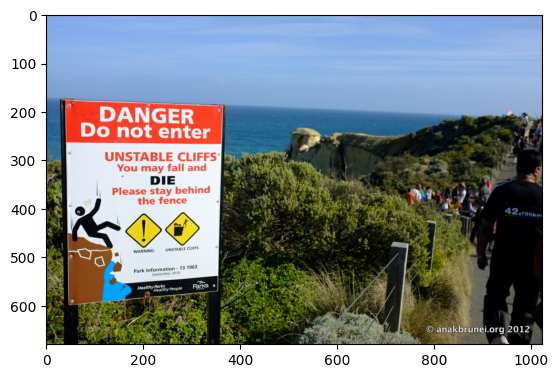

In [146]:
plt.plot(figsize=(20,20))
plt.imshow(images_generator)
plt.show()

## Data Augmentation using Albumentations